In [47]:
%matplotlib inline
from __future__ import print_function

from astropy.io import fits
from scipy import ndimage
import numpy as np
from time import clock
import glob
import h5py

from ppxf import ppxf
import ppxf_util as util

## J17617+4232

In [50]:
def ppxf_kinematics_example_1(): #adapt to KAST

    # Read a galaxy spectrum and define the wavelength range
    #
    #file = 'J1617+4232_coadd.fits'
    #hdu = fits.open(file)
    #gal_lin = hdu[0].data
    #h1 = hdu[0].header
    spec1 = 'J1617+4232_coadd.hdf5'
    a = h5py.File(spec1, 'r')
    a_group_key = a.keys()[0]
    data1 = list(a[a_group_key])[0]
    #np.array(data1)
    wav1 = data1[0]
    flux1 = data1[1]
    mask = ((wav1 > 5000) & (wav1 < 7000))
    wav_use = wav1[mask]
    gal_lin = wav1[mask]
    
    lamRange1 = np.array([np.min(wav_use), np.max(wav_use)])
    FWHM_gal = 4.6  #for KAST, resolution 4.6A
    
    # If the galaxy is at a significant redshift (z > 0.03), one would need to apply
    # a large velocity shift in PPXF to match the template to the galaxy spectrum.
    # This would require a large initial value for the velocity (V > 1e4 km/s)
    # in the input parameter START = [V,sig]. This can cause PPXF to stop!
    # The solution consists of bringing the galaxy spectrum roughly to the
    # rest-frame wavelength, before calling PPXF. In practice there is no
    # need to modify the spectrum before the usual LOG_REBIN, given that a
    # red shift corresponds to a linear shift of the log-rebinned spectrum.
    # One just needs to compute the wavelength range in the rest-frame
    # and adjust the instrumental resolution of the galaxy observations.
    # This is done with the following three commented lines:
    #
    z = 0.441 # Initial estimate of the galaxy redshift
    lamRange1 = lamRange1/(1+z) # Compute approximate restframe wavelength range
    FWHM_gal = FWHM_gal/(1+z)   # Adjust resolution in Angstrom

    galaxy, logLam1, velscale = util.log_rebin(lamRange1, gal_lin)
    galaxy = galaxy/np.median(galaxy)  # Normalize spectrum to avoid numerical issues
    noise = galaxy*0 + 5          # Assume constant noise per pixel here

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
    # of the library is included for this example with permission
    vazdekis = glob.glob('/Users/gsallabe/Downloads/ppxf/miles_models/Mun1.30Z*.fits')
    FWHM_tem = 2.51  # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
    # Extract the wavelength range and logarithmically rebin one spectrum
    # to the same velocity scale of the SAURON galaxy spectrum, to determine
    # the size needed for the array which will contain the template spectra.
    #
    hdu = fits.open(vazdekis[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    lamRange2 = h2['CRVAL1'] + np.array([0., h2['CDELT1']*(h2['NAXIS1'] - 1)])
    sspNew, logLam2, velscale = util.log_rebin(lamRange2, ssp, velscale=velscale)
    templates = np.empty((sspNew.size, len(vazdekis)))

    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SAURON and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SAURON
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2)
    sigma = FWHM_dif/2.355/h2['CDELT1']  # Sigma difference in pixels

    for j, file in enumerate(vazdekis):
        hdu = fits.open(file)
        ssp = hdu[0].data
        ssp = ndimage.gaussian_filter1d(ssp,sigma)
        sspNew, logLam2, velscale = util.log_rebin(lamRange2, ssp, velscale=velscale)
        templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below (see above).
    #
    c = 299792.458
    dv = (logLam2[0] - logLam1[0])*c # km/s

    vel = 133255. # Initial estimate of the galaxy velocity in km/s
    z = np.exp(vel/c) - 1   # Relation between velocity and redshift in pPXF
    goodPixels = util.determine_goodpixels(logLam1, lamRange2, z)

    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    start = [vel, 180.]  # (km/s), starting guess for [V, sigma]
    t = clock()

    pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodPixels, plot=True, moments=4,
              degree=4, vsyst=dv)

    print("Formal errors:")
    print("     dV    dsigma   dh3      dh4")
    print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

    print('Elapsed time in PPXF: %.2f s' % (clock() - t))

    # If the galaxy is at significant redshift z and the wavelength has been
    # de-redshifted with the three lines "z = 1.23..." near the beginning of
    # this procedure, the best-fitting redshift is now given by the following
    # commented line (equation 2 of Cappellari et al. 2009, ApJ, 704, L34;
    # http://adsabs.harvard.edu/abs/2009ApJ...704L..34C)
    #
    #print, 'Best-fitting redshift z:', (z + 1)*(1 + sol[0]/c) - 1

#------------------------------------------------------------------------------
ppxf_kinematics_example_1()

IndexError: index 0 is out of bounds for axis 0 with size 0

## J1620+4227

Best Fit:       Vel     sigma        h3        h4
 comp. 0:       491         1    -0.000    -0.001
chi2/DOF: 4.311e+05
method = capfit ; Jac calls: 4 ; Func calls: 25 ; Status: 2
Nonzero Templates:  1  /  144
Formal errors:
     dV    dsigma   dh3      dh4
   5e+04 6.9e+04 4.7e+04 4.7e+04
Elapsed time in PPXF: 2.17 s


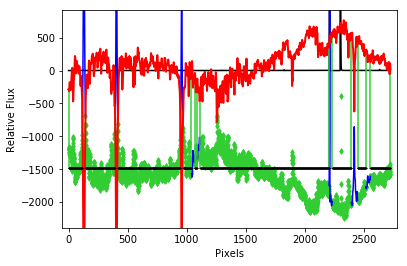

In [39]:
def ppxf_kinematics_example_2(): #adapt to KAST

    # Read a galaxy spectrum and define the wavelength range
    #
    file = 'J1620+4227_coadd.fits'
    hdu = fits.open(file)
    gal_lin = hdu[0].data
    h1 = hdu[0].header

    lamRange1 = np.array([4000., 7000.])
    FWHM_gal = 4.6  #for KAST, resolution 4.6A
    
    # If the galaxy is at a significant redshift (z > 0.03), one would need to apply
    # a large velocity shift in PPXF to match the template to the galaxy spectrum.
    # This would require a large initial value for the velocity (V > 1e4 km/s)
    # in the input parameter START = [V,sig]. This can cause PPXF to stop!
    # The solution consists of bringing the galaxy spectrum roughly to the
    # rest-frame wavelength, before calling PPXF. In practice there is no
    # need to modify the spectrum before the usual LOG_REBIN, given that a
    # red shift corresponds to a linear shift of the log-rebinned spectrum.
    # One just needs to compute the wavelength range in the rest-frame
    # and adjust the instrumental resolution of the galaxy observations.
    # This is done with the following three commented lines:
    #
    #z = 0.441 # Initial estimate of the galaxy redshift
    #lamRange1 = lamRange1/(1+z) # Compute approximate restframe wavelength range
    #FWHM_gal = FWHM_gal/(1+z)   # Adjust resolution in Angstrom

    galaxy, logLam1, velscale = util.log_rebin(lamRange1, gal_lin)
    galaxy = galaxy/np.median(galaxy)  # Normalize spectrum to avoid numerical issues
    noise = galaxy*0 + 5          # Assume constant noise per pixel here

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
    # of the library is included for this example with permission
    vazdekis = glob.glob('/Users/gsallabe/Downloads/ppxf/miles_models/Mun1.30Z*.fits')
    FWHM_tem = 2.51  # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
    # Extract the wavelength range and logarithmically rebin one spectrum
    # to the same velocity scale of the SAURON galaxy spectrum, to determine
    # the size needed for the array which will contain the template spectra.
    #
    hdu = fits.open(vazdekis[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    lamRange2 = h2['CRVAL1'] + np.array([0., h2['CDELT1']*(h2['NAXIS1'] - 1)])
    sspNew, logLam2, velscale = util.log_rebin(lamRange2, ssp, velscale=velscale)
    templates = np.empty((sspNew.size, len(vazdekis)))

    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SAURON and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SAURON
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2)
    sigma = FWHM_dif/2.355/h2['CDELT1']  # Sigma difference in pixels

    for j, file in enumerate(vazdekis):
        hdu = fits.open(file)
        ssp = hdu[0].data
        ssp = ndimage.gaussian_filter1d(ssp,sigma)
        sspNew, logLam2, velscale = util.log_rebin(lamRange2, ssp, velscale=velscale)
        templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below (see above).
    #
    c = 299792.458
    dv = (logLam2[0] - logLam1[0])*c # km/s

    vel = 450. # Initial estimate of the galaxy velocity in km/s
    z = np.exp(vel/c) - 1   # Relation between velocity and redshift in pPXF
    goodPixels = util.determine_goodpixels(logLam1, lamRange2, z)

    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    start = [vel, 180.]  # (km/s), starting guess for [V, sigma]
    t = clock()

    pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodPixels, plot=True, moments=4,
              degree=4, vsyst=dv)

    print("Formal errors:")
    print("     dV    dsigma   dh3      dh4")
    print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

    print('Elapsed time in PPXF: %.2f s' % (clock() - t))

    # If the galaxy is at significant redshift z and the wavelength has been
    # de-redshifted with the three lines "z = 1.23..." near the beginning of
    # this procedure, the best-fitting redshift is now given by the following
    # commented line (equation 2 of Cappellari et al. 2009, ApJ, 704, L34;
    # http://adsabs.harvard.edu/abs/2009ApJ...704L..34C)
    #
    #print, 'Best-fitting redshift z:', (z + 1)*(1 + sol[0]/c) - 1

#------------------------------------------------------------------------------
ppxf_kinematics_example_2()

## J2223+0137

Best Fit:       Vel     sigma        h3        h4
 comp. 0:       590         1     0.000    -0.001
chi2/DOF: 7661
method = capfit ; Jac calls: 5 ; Func calls: 28 ; Status: 2
Nonzero Templates:  1  /  144
Formal errors:
     dV    dsigma   dh3      dh4
   6e+04 4.3e+05 5.6e+04 4.5e+05
Elapsed time in PPXF: 2.23 s


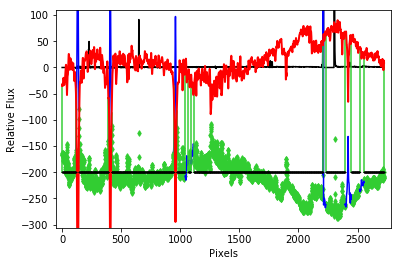

In [40]:
def ppxf_kinematics_example_3(): #adapt to KAST

    # Read a galaxy spectrum and define the wavelength range
    #
    file = 'J2223+0137_coadd.fits'
    hdu = fits.open(file)
    gal_lin = hdu[0].data
    h1 = hdu[0].header

    lamRange1 = np.array([4000., 7000.])
    FWHM_gal = 4.6  #for KAST, resolution 4.6A
    
    # If the galaxy is at a significant redshift (z > 0.03), one would need to apply
    # a large velocity shift in PPXF to match the template to the galaxy spectrum.
    # This would require a large initial value for the velocity (V > 1e4 km/s)
    # in the input parameter START = [V,sig]. This can cause PPXF to stop!
    # The solution consists of bringing the galaxy spectrum roughly to the
    # rest-frame wavelength, before calling PPXF. In practice there is no
    # need to modify the spectrum before the usual LOG_REBIN, given that a
    # red shift corresponds to a linear shift of the log-rebinned spectrum.
    # One just needs to compute the wavelength range in the rest-frame
    # and adjust the instrumental resolution of the galaxy observations.
    # This is done with the following three commented lines:
    #
    #z = 0.441 # Initial estimate of the galaxy redshift
    #lamRange1 = lamRange1/(1+z) # Compute approximate restframe wavelength range
    #FWHM_gal = FWHM_gal/(1+z)   # Adjust resolution in Angstrom

    galaxy, logLam1, velscale = util.log_rebin(lamRange1, gal_lin)
    galaxy = galaxy/np.median(galaxy)  # Normalize spectrum to avoid numerical issues
    noise = galaxy*0 + 5          # Assume constant noise per pixel here

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
    # of the library is included for this example with permission
    vazdekis = glob.glob('/Users/gsallabe/Downloads/ppxf/miles_models/Mun1.30Z*.fits')
    FWHM_tem = 2.51  # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
    # Extract the wavelength range and logarithmically rebin one spectrum
    # to the same velocity scale of the SAURON galaxy spectrum, to determine
    # the size needed for the array which will contain the template spectra.
    #
    hdu = fits.open(vazdekis[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    lamRange2 = h2['CRVAL1'] + np.array([0., h2['CDELT1']*(h2['NAXIS1'] - 1)])
    sspNew, logLam2, velscale = util.log_rebin(lamRange2, ssp, velscale=velscale)
    templates = np.empty((sspNew.size, len(vazdekis)))

    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SAURON and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SAURON
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2)
    sigma = FWHM_dif/2.355/h2['CDELT1']  # Sigma difference in pixels

    for j, file in enumerate(vazdekis):
        hdu = fits.open(file)
        ssp = hdu[0].data
        ssp = ndimage.gaussian_filter1d(ssp,sigma)
        sspNew, logLam2, velscale = util.log_rebin(lamRange2, ssp, velscale=velscale)
        templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below (see above).
    #
    c = 299792.458
    dv = (logLam2[0] - logLam1[0])*c # km/s

    vel = 450. # Initial estimate of the galaxy velocity in km/s
    z = np.exp(vel/c) - 1   # Relation between velocity and redshift in pPXF
    goodPixels = util.determine_goodpixels(logLam1, lamRange2, z)

    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    start = [vel, 180.]  # (km/s), starting guess for [V, sigma]
    t = clock()

    pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodPixels, plot=True, moments=4,
              degree=4, vsyst=dv)

    print("Formal errors:")
    print("     dV    dsigma   dh3      dh4")
    print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

    print('Elapsed time in PPXF: %.2f s' % (clock() - t))

    # If the galaxy is at significant redshift z and the wavelength has been
    # de-redshifted with the three lines "z = 1.23..." near the beginning of
    # this procedure, the best-fitting redshift is now given by the following
    # commented line (equation 2 of Cappellari et al. 2009, ApJ, 704, L34;
    # http://adsabs.harvard.edu/abs/2009ApJ...704L..34C)
    #
    #print, 'Best-fitting redshift z:', (z + 1)*(1 + sol[0]/c) - 1

#------------------------------------------------------------------------------
ppxf_kinematics_example_3()

## J2240+0053

Best Fit:       Vel     sigma        h3        h4
 comp. 0:       493         1    -0.001    -0.001
chi2/DOF: 1.901e+05
method = capfit ; Jac calls: 4 ; Func calls: 25 ; Status: 2
Nonzero Templates:  1  /  144
Formal errors:
     dV    dsigma   dh3      dh4
 4.9e+04 1.6e+05 4.7e+04 1.3e+05
Elapsed time in PPXF: 1.95 s


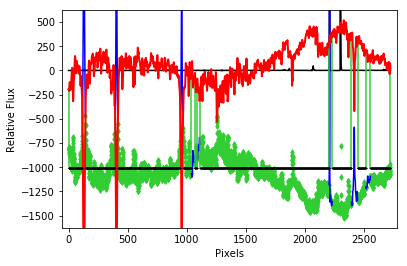

In [41]:
def ppxf_kinematics_example_4(): #adapt to KAST

    # Read a galaxy spectrum and define the wavelength range
    #
    file = 'J2240+0053_coadd.fits'
    hdu = fits.open(file)
    gal_lin = hdu[0].data
    h1 = hdu[0].header

    lamRange1 = np.array([4000., 7000.])
    FWHM_gal = 4.6  #for KAST, resolution 4.6A
    
    # If the galaxy is at a significant redshift (z > 0.03), one would need to apply
    # a large velocity shift in PPXF to match the template to the galaxy spectrum.
    # This would require a large initial value for the velocity (V > 1e4 km/s)
    # in the input parameter START = [V,sig]. This can cause PPXF to stop!
    # The solution consists of bringing the galaxy spectrum roughly to the
    # rest-frame wavelength, before calling PPXF. In practice there is no
    # need to modify the spectrum before the usual LOG_REBIN, given that a
    # red shift corresponds to a linear shift of the log-rebinned spectrum.
    # One just needs to compute the wavelength range in the rest-frame
    # and adjust the instrumental resolution of the galaxy observations.
    # This is done with the following three commented lines:
    #
    #z = 0.441 # Initial estimate of the galaxy redshift
    #lamRange1 = lamRange1/(1+z) # Compute approximate restframe wavelength range
    #FWHM_gal = FWHM_gal/(1+z)   # Adjust resolution in Angstrom

    galaxy, logLam1, velscale = util.log_rebin(lamRange1, gal_lin)
    galaxy = galaxy/np.median(galaxy)  # Normalize spectrum to avoid numerical issues
    noise = galaxy*0 + 5          # Assume constant noise per pixel here

    # Read the list of filenames from the Single Stellar Population library
    # by Vazdekis (2010, MNRAS, 404, 1639) http://miles.iac.es/. A subset
    # of the library is included for this example with permission
    vazdekis = glob.glob('/Users/gsallabe/Downloads/ppxf/miles_models/Mun1.30Z*.fits')
    FWHM_tem = 2.51  # Vazdekis+10 spectra have a constant resolution FWHM of 2.51A.
    # Extract the wavelength range and logarithmically rebin one spectrum
    # to the same velocity scale of the SAURON galaxy spectrum, to determine
    # the size needed for the array which will contain the template spectra.
    #
    hdu = fits.open(vazdekis[0])
    ssp = hdu[0].data
    h2 = hdu[0].header
    lamRange2 = h2['CRVAL1'] + np.array([0., h2['CDELT1']*(h2['NAXIS1'] - 1)])
    sspNew, logLam2, velscale = util.log_rebin(lamRange2, ssp, velscale=velscale)
    templates = np.empty((sspNew.size, len(vazdekis)))

    # Convolve the whole Vazdekis library of spectral templates
    # with the quadratic difference between the SAURON and the
    # Vazdekis instrumental resolution. Logarithmically rebin
    # and store each template as a column in the array TEMPLATES.

    # Quadratic sigma difference in pixels Vazdekis --> SAURON
    # The formula below is rigorously valid if the shapes of the
    # instrumental spectral profiles are well approximated by Gaussians.
    #
    FWHM_dif = np.sqrt(FWHM_gal**2 - FWHM_tem**2)
    sigma = FWHM_dif/2.355/h2['CDELT1']  # Sigma difference in pixels

    for j, file in enumerate(vazdekis):
        hdu = fits.open(file)
        ssp = hdu[0].data
        ssp = ndimage.gaussian_filter1d(ssp,sigma)
        sspNew, logLam2, velscale = util.log_rebin(lamRange2, ssp, velscale=velscale)
        templates[:, j] = sspNew/np.median(sspNew)  # Normalizes templates

    # The galaxy and the template spectra do not have the same starting wavelength.
    # For this reason an extra velocity shift DV has to be applied to the template
    # to fit the galaxy spectrum. We remove this artificial shift by using the
    # keyword VSYST in the call to PPXF below, so that all velocities are
    # measured with respect to DV. This assume the redshift is negligible.
    # In the case of a high-redshift galaxy one should de-redshift its
    # wavelength to the rest frame before using the line below (see above).
    #
    c = 299792.458
    dv = (logLam2[0] - logLam1[0])*c # km/s

    vel = 450. # Initial estimate of the galaxy velocity in km/s
    z = np.exp(vel/c) - 1   # Relation between velocity and redshift in pPXF
    goodPixels = util.determine_goodpixels(logLam1, lamRange2, z)

    # Here the actual fit starts. The best fit is plotted on the screen.
    # Gas emission lines are excluded from the pPXF fit using the GOODPIXELS keyword.
    #
    start = [vel, 180.]  # (km/s), starting guess for [V, sigma]
    t = clock()

    pp = ppxf(templates, galaxy, noise, velscale, start,
              goodpixels=goodPixels, plot=True, moments=4,
              degree=4, vsyst=dv)

    print("Formal errors:")
    print("     dV    dsigma   dh3      dh4")
    print("".join("%8.2g" % f for f in pp.error*np.sqrt(pp.chi2)))

    print('Elapsed time in PPXF: %.2f s' % (clock() - t))

    # If the galaxy is at significant redshift z and the wavelength has been
    # de-redshifted with the three lines "z = 1.23..." near the beginning of
    # this procedure, the best-fitting redshift is now given by the following
    # commented line (equation 2 of Cappellari et al. 2009, ApJ, 704, L34;
    # http://adsabs.harvard.edu/abs/2009ApJ...704L..34C)
    #
    #print, 'Best-fitting redshift z:', (z + 1)*(1 + sol[0]/c) - 1

#------------------------------------------------------------------------------
ppxf_kinematics_example_4()